# Analyse slip velocity particle
In this notebook I analyse the slip velocity (difference fluid velocity and particle velocity)   
to make an estimation for the Reynolds partilcle number ($Re_p = U_{slip} d / \nu $). As  
pointed out by Irina, $Re_p$ might not be small and thus additional corrections to the Stokes  
drag force in the form of $\nu\rightarrow\nu_{eff}=\nu c(Re_p) = \nu(1+f(RE_p))$ should be added.       
To investigate this we measure the slip velocity in simulations with MR advection using:  
1. stokes drag
2. drag with  $c(Re_p)$ dependend drag   
And we do this for the slow manifold and full MR equation. We also investigate:   
1. variability $Re_p$
2. spin up time simulation (how mcuh time is needed before  slip velocity / $Re_p$ stabilizes)
32. effect of different timesteps


In [1]:
# import needed packages

#update reading in packages when rerunning this cell
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
from scipy.optimize import fsolve

from datetime import datetime, timedelta
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/src")
from analysis_functions_xr import trajectory_length, Haversine_list, calc_tidal_av
from analysis_functions import make_PDF
from particle_characteristics_functions import factor_drag_white1991, factor_drag_Schiller1933, factor_drag_morrison2013, Re_particle

sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')
# plotstyle:
color_array = np.array(['c','orange','purple','black'])
marker_array = np.array(['s','o','>','p'])
line_array = np.array(['-','--','-.',':'])
markerline_array = np.array(['-s','--o','-.>',':p'])





In [2]:
# set needed constants
Rearth = 6371 * 10**3 # in m,
deg2rad = np.pi / 180.
sec_in_hours= 3600
diameter = 0.2 #m
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


13.722228155251866


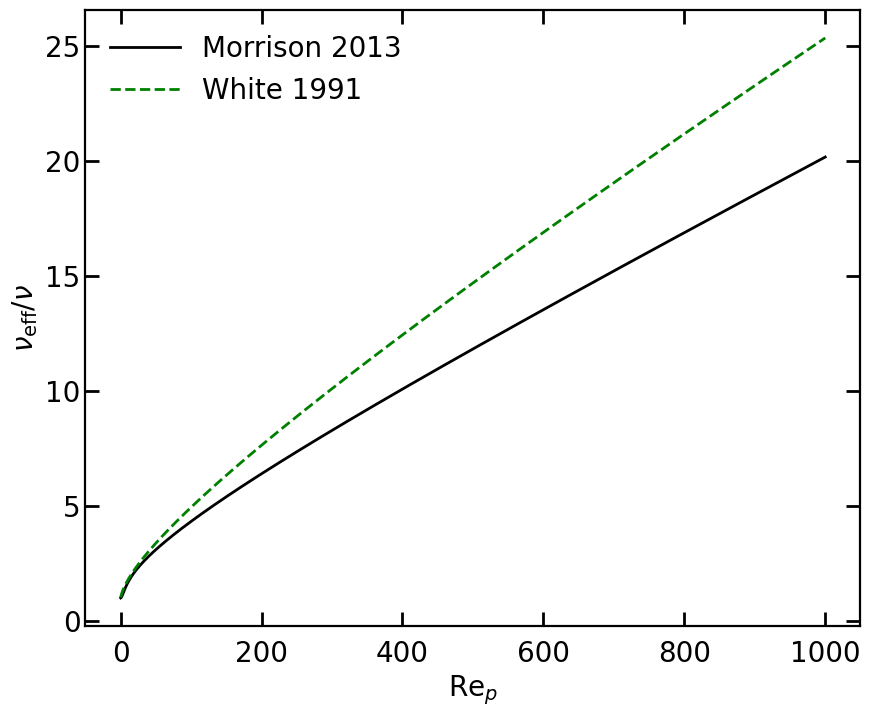

In [3]:
#compare drag factors

fig,ax = plt.subplots()
rep = np.logspace(-1,3,1000)
ax.plot(rep,factor_drag_morrison2013(rep),'-',color='k')
ax.plot(rep,factor_drag_white1991(rep),'--',color='green')
# ax.plot(rep,1+0.095*rep**0.8,'--',color='red')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Re$_p$')
# ax.set_ylabel('c(Re$_p$)')
ax.set_ylabel('$\\nu_{\\mathrm{eff}}/\\nu$')
ax.legend(['Morrison 2013','White 1991'])

print(factor_drag_white1991(457))
# we use white 1991 throughout as it is a way simpler expression and still does a very good job up to 10^5

# constant reynolds number
We perform simulation using drag force with $c(\mathrm{Re}_p)$ and measure the slip velocity  
we use this slip veloctity to calculated the measured $\mathrm{Re}_p$  
we compare the input $\mathrm{Re}_p$ with the measured $\mathrm{Re}_p$. The goal is to find  
the Reynolds number for which the input and measured $\mathrm{Re}_p$ are the same.  
We first use a short simulation of 24 hours where we save the slip velocity every 5 min and  
advect the particles using the slow manifold MR equation (more stable for high Reynolds numbers)  


## 24 hours sim with slow manifold

In [ ]:
# read in data
Replist_SM = np.array([1,10,50,300,400,450,500,1000,5000])
file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')

#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime
particle_type = 'inertial_SM_Rep_constant'

chunck_time = 100
nparticles = 88347
data_SM_Rep_constant_24h = {}
for Rep in Replist_SM: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis,
                                                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    data_SM_Rep_constant_24h[Rep]=ds

In [ ]:
# plot selection of slip velocities
fig, ax = plt.subplots()
Replist_selection=np.array([300,500,1000,5000])
i=0
id=0
legend = []
for Rep in Replist_selection:
    ax.plot((data_SM_Rep_constant_24h[Rep].time[id,1:]-data_SM_Rep_constant_24h[Rep].time[id,0])/sec_in_hours,data_SM_Rep_constant_24h[Rep].uf[id,1:],marker_array[i],color=color_array[i])   
    legend.append('$\\mathrm{Re_p} =$' +  f'{Rep}')
    i+=1

ax.legend(legend)
ax.set_xlabel('time [hours]')
ax.set_ylabel('zonal slip velocity [m/s]')


In [ ]:
# make PDF and CDF for every particle Reynolds number
mean_SM_Rep_c_day={}
bins_SM_Rep_c_day={}
pdfs_SM_Rep_c_day={}
cdfs_SM_Rep_c_day={}

for Rep in Replist_SM:
    Re_p =Re_particle(data_SM_Rep_constant_24h[Rep].Uslip,diameter, kinematic_viscosity_water)

    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]
  
    mean_SM_Rep_c_day[Rep]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_SM_Rep_c_day[Rep]=bins
    pdfs_SM_Rep_c_day[Rep]=pdf
    cdfs_SM_Rep_c_day[Rep]=cdf

In [ ]:
# plot pdfs
fig, ax = plt.subplots()

for Rep, color, marker in zip(Replist_selection, color_array, marker_array):
   ax.plot(bins_SM_Rep_c_day[Rep],pdfs_SM_Rep_c_day[Rep],marker,color=color)
ax.legend(np.char.add('Re$_p$ = ',  Replist_selection.astype(str)))
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

In [ ]:
# plot cdfs
fig, ax = plt.subplots()
for Rep, color, marker in zip(Replist_selection, color_array, line_array):
   
   ax.plot(bins_SM_Rep_c_day[Rep],cdfs_SM_Rep_c_day[Rep],marker,color=color)
   i+=1 

ax.legend(np.char.add('Re$_p$ = ', Replist_selection.astype(str)))
ax.set_xscale('log')

ax.set_ylabel('CDF')
ax.set_xlabel('Re$_p$')

In [ ]:
# plot selection of trajectories for which slip velocities is bigger than threshold
Rep = 450
threshold = 0.1 # 0.1 # treshhold for slip velocity
above_threshold = data_SM_Rep_constant_24h[Rep].lon.where(data_SM_Rep_constant_24h[Rep].Uslip > threshold).notnull().any(dim='obs')

# Select trajectories that meet the condition
filtered_trajectories = data_SM_Rep_constant_24h[Rep].sel(trajectory=above_threshold)
# find index of maximum slip velocity for the selected trajectories
idmax= filtered_trajectories.Uslip.idxmax(dim='obs', skipna=True)

# plot selected trajectories and location of the maximum
fig,ax=plt.subplots(figsize=(30,8),
                     subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')

#plot selection trajectories
ax.plot(filtered_trajectories.lon.T,filtered_trajectories.lat.T,color='grey',linewidth=1);
#plot location maximum (not perse on land)
ax.plot(filtered_trajectories.lon.sel(obs =idmax).T,filtered_trajectories.lat.sel(obs =idmax).T,'o',color='red',markersize=5,markeredgewidth = 1, markeredgecolor = 'black');

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0, color='gray', alpha=0.5, linestyle='--')
# ax.set_xlim(-3.7,-2.5)
# ax.set_ylim(58.3,59.5)


### Estimate when measured and input particle reynolds number are the same
To estimate when the measured and input reynolds number are the same we use the  
fact that the slip velocity scales with $C(\mathrm{Re}_p^{\mathrm{in}})$, Thus we try   
to predict $\mathrm{Re}_p^{\mathrm{m}}$ using a single reference measurement with   
$\mathrm{Re}_{p,\mathrm{ref}}^{\mathrm{in}}$ resulting in $\mathrm{Re}_{p,\mathrm{ref}}^{\mathrm{m}}$  
Then we calculate the  $\mathrm{Re}_p^{\mathrm{measured}}$ using:   
$$  \mathrm{Re}_p^{\mathrm{m}}=\frac{\mathrm{Re}_{p,\mathrm{ref}}^{\mathrm{m}}  C(\mathrm{Re}_{p,\mathrm{ref}}^{\mathrm{in}})}{C(\mathrm{Re}_{p}^{\mathrm{in}}) }  $$

In [ ]:
# define functions needed to estimate the measured Rep based on a single reference measured
def Rep_measured(Rep_in, Rep_ref_in, Rep_ref_measured):
    return Rep_ref_measured * factor_drag_white1991(Rep_ref_in)/factor_drag_white1991(Rep_in)

def Rep_in_measured_root(Rep_in, Rep_ref_in, Rep_ref_measured):
   return Rep_measured(Rep_in, Rep_ref_in, Rep_ref_measured)-Rep_in

In [ ]:
# 

Repmeasured_SM = [mean_SM_Rep_c_day[Rep] for Rep in Replist_SM]
# find solution for when measured Rep is equal to input Rep
solution = [fsolve(Rep_in_measured_root, 450, args=(Repi, Repm))[0] for Repi,Repm in zip(Replist_SM,Repmeasured_SM)]
Rep_fit = np.array(solution).mean()

#plotting
fig, ax = plt.subplots()
# plot measured points
ax.plot(Replist_SM,Repmeasured_SM,'o',color='navy')
# plot predicted solution based on single value 
Reprange = np.logspace(-1,4,1000)
ax.plot(Reprange,Repmeasured_SM[5] * factor_drag_white1991(Replist_SM[5])/factor_drag_white1991(Reprange),'--',zorder=-5,color='navy')
#legend
ax.legend(['simulated Re$_p^m$','predicted Re$_p^m$'])
# plot fitted solution
ax.plot(Reprange,Reprange,color='grey',zorder=-10)
ax.text(85,60,'Re$_p^{in}$ = Re$_p^m$ = '+f'{Rep_fit:.2f}',color='grey',fontsize=15)
# label layout
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.1,10**4)
ax.set_ylim(0.1,10**4)
ax.set_xlabel('Re$_p^{in}$')
ax.set_ylabel('Re$_p^{m}$')

# #print solution
# print(f'Rep fit = {Rep_fit:.2f}')


## 24 hours sim full MR 
To check that the SM and full MR agree we also performed full MR simulations for a supset or the Rep input values used in the SM MR sim

In [ ]:
#import data
Replist = np.array([300,500, 1000, 5000])
file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')
#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime
particle_type = 'inertial_Rep_constant'

chunck_time = 100
nparticles = 88347
data_Rep_constant_24h = {}
for Rep in Replist: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis,
                                                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    data_Rep_constant_24h[Rep]=ds

In [ ]:
id=1
fig, ax = plt.subplots()
i=0


for Rep, color, marker in zip(Replist,color_array,marker_array):
    ax.plot((data_Rep_constant_24h[Rep].time[id]-data_Rep_constant_24h[Rep].time[id,0])*sec_in_hours,data_Rep_constant_24h[Rep].uf[id],marker,color=color)   


ax.legend(np.char.add('Re$_p$ = ',  Replist.astype(str)))
ax.set_ylabel('zonal slip velocity [m/s]')
ax.set_xlabel('time [hours]')

In [ ]:
# make PDF and CDF for reynoldsnumber
mean_Rep_c_day={}
bins_Rep_c_day={}
pdfs_Rep_c_day={}
cdfs_Rep_c_day={}

for Rep in Replist:
    Re_p = Re_particle(data_Rep_constant_24h[Rep].Uslip,diameter, kinematic_viscosity_water)
    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]

    mean_Rep_c_day[Rep]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_c_day[Rep]=bins
    pdfs_Rep_c_day[Rep]=pdf
    cdfs_Rep_c_day[Rep]=cdf

In [ ]:
# plot pdfs
fig, ax = plt.subplots()
i=0
for Rep, color, marker in zip(Replist[0:4], color_array, marker_array):
   ax.plot(bins_Rep_c_day[Rep],pdfs_Rep_c_day[Rep],marker,color=color)
ax.legend(np.char.add('Re$_p$ = ',  Replist[0:4].astype(str)))
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

In [ ]:
# plot cdfs
fig, ax = plt.subplots()
i=0
for Rep in Replist[0:4]:
   
   ax.plot(bins_Rep_c_day[Rep],cdfs_Rep_c_day[Rep],line_array[i],color=color_array[i])
   i+=1 

ax.legend(np.char.add('Re$_p$ = ',  Replist[0:4].astype(str)))
ax.set_xscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

In [ ]:
# compare with fit and measured values
Repmeasured = [mean_Rep_c_day[Rep] for Rep in Replist]
#plotting
fig, ax = plt.subplots()
# plot measured points

ax.plot(Replist,Repmeasured,'s',color='firebrick')
ax.plot(Replist_SM,Repmeasured_SM,'o',color='navy')
# plot predicted solution based on single value 
Reprange = np.logspace(-1,4,1000)
ax.plot(Reprange,Repmeasured_SM[5] * factor_drag_white1991(Replist_SM[5])/factor_drag_white1991(Reprange),'--',zorder=-5,color='navy')
#legend
ax.legend(['simulated Re$_p^m$ ','simulated Re$_p^m$ SM','predicted Re$_p^m$'])
# plot fitted solution
ax.plot(Reprange,Reprange,color='grey',zorder=-10)
ax.text(85,60,'Re$_p^{in}$ = Re$_p^m$ = '+f'{Rep_fit:.2f}',color='grey',fontsize=15)
# label layout
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.1,10**4)
ax.set_ylim(0.1,10**4)
ax.set_xlabel('Re$_p^{in}$')
ax.set_ylabel('Re$_p^{m}$')
# does agree :)

# 24 h  simulation with timevarying drag coefficient
Try time varying drag coefficient with SM MR and full MR 

In [56]:
# import data
particle_types = ['inertial_SM_drag_Rep','inertial_drag_Rep']
file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')
#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime
particle_type = 'inertial_Rep_constant'
Rep = 457

chunck_time = 100
nparticles = 88347
data_Rep_var_24h = {}
for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis,
                                                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    data_Rep_var_24h[particle_type]=ds


Text(0.5, 0, 'time [hours]')

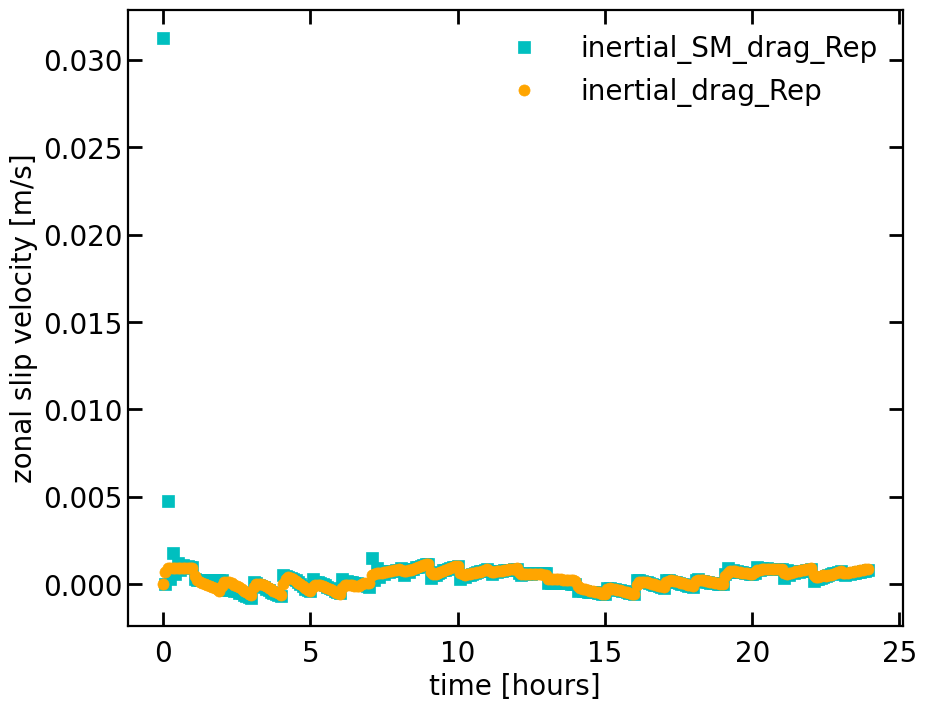

In [57]:

id=1
fig, ax = plt.subplots()

for particle_type, color, marker in zip(particle_types,color_array,marker_array):
    ax.plot((data_Rep_var_24h[particle_type].time[id]-data_Rep_var_24h[particle_type].time[id,0])/sec_in_hours,data_Rep_var_24h[particle_type].uf[id],marker,color=color)   


ax.legend(particle_types)
ax.set_ylabel('zonal slip velocity [m/s]')
ax.set_xlabel('time [hours]')

In [58]:
# make PDF and CDF for reynoldsnumber
mean_Rep_var_day={}
bins_Rep_var_day={}
pdfs_Rep_var_day={}
cdfs_Rep_var_day={}

for pt in particle_types:
    Re_p = Re_particle(data_Rep_var_24h[pt].Uslip,diameter, kinematic_viscosity_water)
    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]
    array=array[array<100000]

    mean_Rep_var_day[pt]=np.mean(array)
    
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_var_day[pt]=bins
    pdfs_Rep_var_day[pt]=pdf
    cdfs_Rep_var_day[pt]=cdf

Text(0.5, 0, 'Re$_p$')

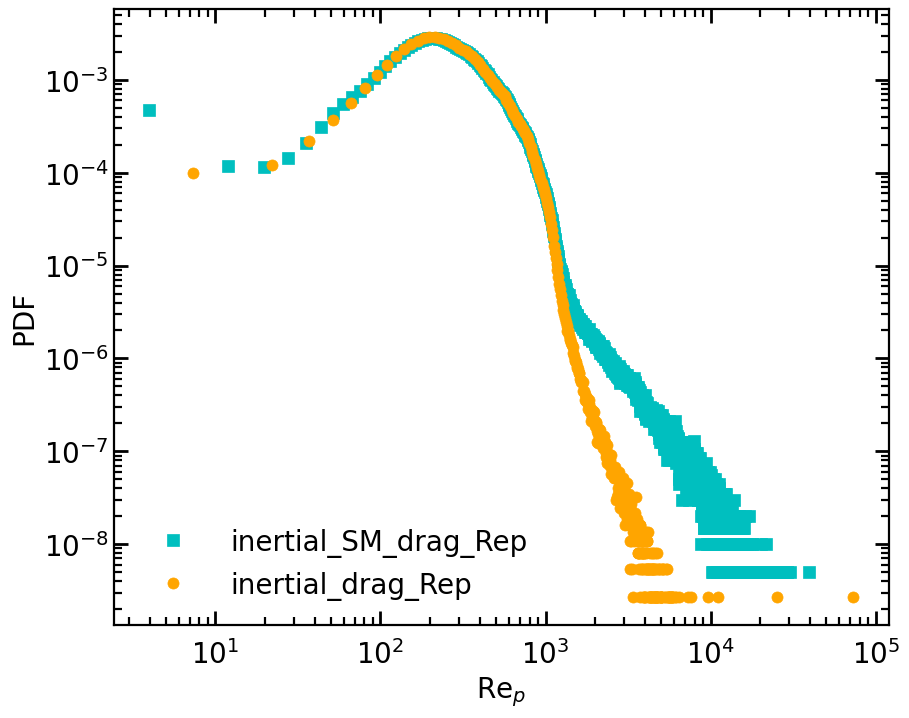

In [59]:
# plot pdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,marker_array,color_array):
   
   ax.plot(bins_Rep_var_day[pt],pdfs_Rep_var_day[pt],marker,color=color)


ax.legend(particle_types)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

# full MR unstable for some partciles s

Text(0.5, 0, 'Re$_p$')

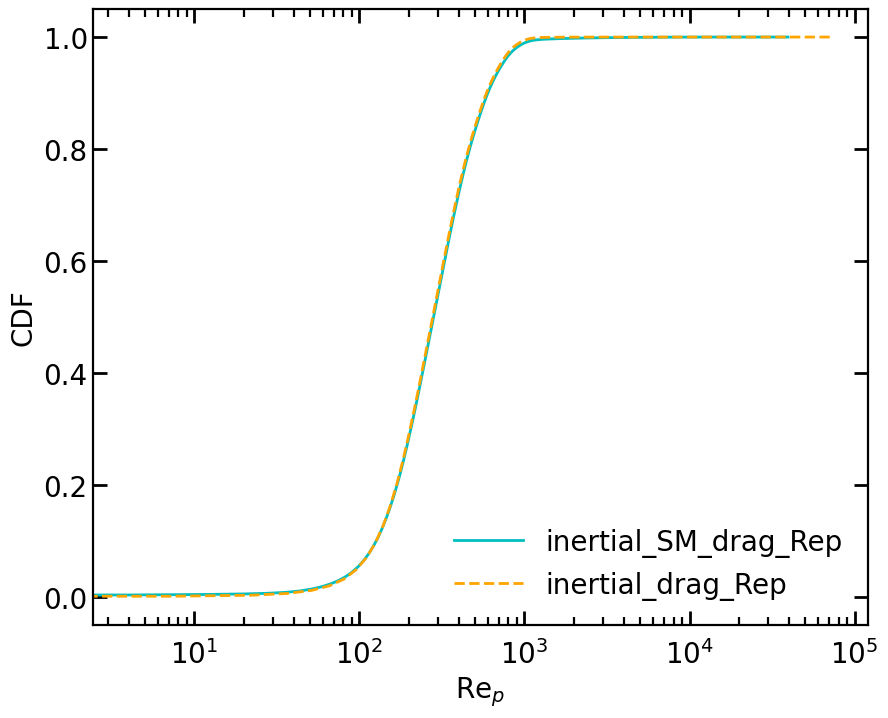

In [60]:
# plot cdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,line_array,color_array):
   
   ax.plot(bins_Rep_var_day[pt],cdfs_Rep_var_day[pt],marker,color=color)


ax.legend(particle_types)
ax.set_xscale('log')

ax.set_ylabel('CDF')
ax.set_xlabel('Re$_p$')

In [62]:
for pt in particle_types:
    print(mean_Rep_var_day[pt])
    print(factor_drag_morrison2013(mean_Rep_var_day[pt]))

339.70752
9.001057502749388
330.69174
8.838449964924285


(46.0, 61.3)

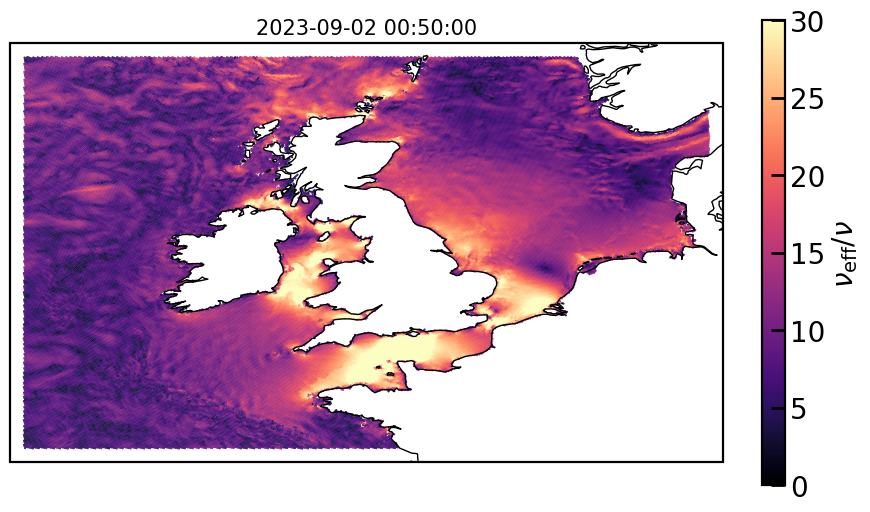

In [9]:
# scatter plot for reynolds number 
pt = 'inertial_SM_drag_Rep'
Re_p = Re_particle(data_Rep_var_24h[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
tid = 10


fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
sec = float(data_Rep_var_24h[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
ax.set_title(f'{date}', fontsize=15)
scp = ax.scatter(data_Rep_var_24h[pt].lon[::1,tid].T,data_Rep_var_24h[pt].lat[::1,tid].T,c=c_rep[::1,tid].T,s=0.3, vmin=0,vmax=30,cmap='magma')
fig.colorbar(scp,label='$\\nu_{\\mathrm{eff}}/\\nu$',fraction=0.03)
ax.set_xlim(-16,10)
ax.set_ylim(46,61.3)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


KeyboardInterrupt: 

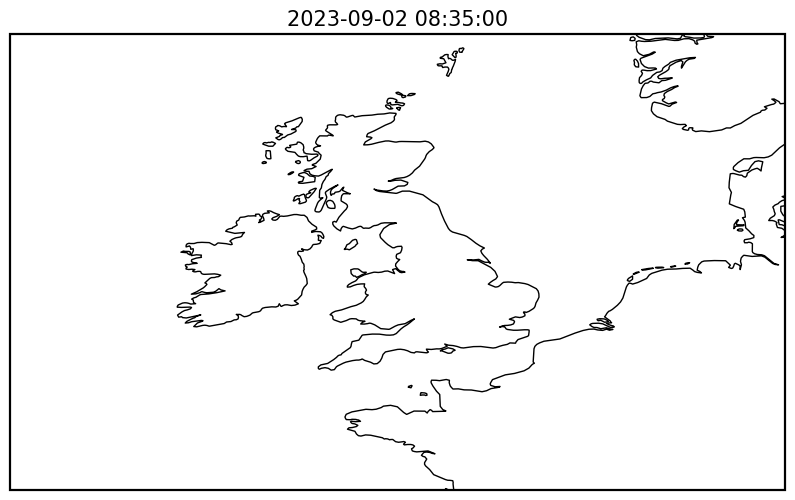

In [10]:
# make movie out of it
pt = 'inertial_drag_Rep'
Re_p = Re_particle(data_Rep_var_24h[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
for tid in range(1,288,1):

    print(tid)

    fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    sec = float(data_Rep_var_24h[pt].time[0,tid].values)
    date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
    ax.set_title(f'{date}', fontsize=15)
    ax.coastlines()
    ax.set_xlim(-16,10)
    ax.set_ylim(46,61.3)
    scp = ax.scatter(data_Rep_var_24h[pt].lon[::1,tid].T,data_Rep_var_24h[pt].lat[::1,tid].T,c=c_rep[::1,tid].T,s=0.3, vmin=0,vmax=20)
    fig.colorbar(scp,label='$Re_p$',fraction=0.03)
    fig.tight_layout()
    fig.savefig(f'/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/figures/lagrangian_field/frames/september/Re_particle/24_h_hourly_field/crep/frames{tid:04d}.png')
    plt.close(fig)
# ffmpeg -framerate 20 -i frames%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 scatter_MR_c_rep_drag.mp4
# ffmpeg -framerate 20 -i frames%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 scatter_MRSM_hourly_field_c_rep_drag.mp4
# ffmpeg -framerate 20 -i frames%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 scatter_MRSM_daily_field_c_rep_drag.mp4



In [ ]:
data_Rep_var_24h[pt].lon.shape

## 1 month simulations constant Rep
1 month sim with both full MR and slow manifold using $\mathrm{Re}_p^{\mathrm{in}} = 457$
and hourly output


In [ ]:
file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_Rep_{Rep:04d}_slip_velocity.zarr')

#settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 1, 0, 0, 0, 0)
endtime = starttime + runtime
particle_types = ['inertial_SM_Rep_constant','inertial_Rep_constant']
data_Rep_constant_1month={}
chunck_time = 100
nparticles = 88347
Rep = 457
for pt in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = pt,
                            y_s=starttime.year,
                            m_s=starttime.month,
                            d_s=starttime.day,
                            y_e=endtime.year,
                            m_e=endtime.month,
                            d_e=endtime.day,
                            B = int(B * 1000), 
                            tau = int(tau ),
                            land_handling = land_handling, 
                            cor_on = coriolis,
                            Rep = Rep )
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    data_Rep_constant_1month[pt]=ds

In [ ]:

id=1
fig, ax = plt.subplots()

for pt, color, marker in zip(particle_types,color_array,marker_array):
    ax.plot((data_Rep_constant_1month[pt].time[id]-data_Rep_constant_1month[pt].time[id,0])/sec_in_hours/24,data_Rep_constant_1month[pt].uf[id],marker,color=color)   


ax.legend(particle_types)
ax.set_ylabel('zonal slip velocity [m/s]')
ax.set_xlabel('time [days]')

In [ ]:
# make PDF and CDF for reynoldsnumber
mean_Rep_c_month={}
bins_Rep_c_month={}
pdfs_Rep_c_month={}
cdfs_Rep_c_month={}
mean_Rep_c_over_month={}

for pt in particle_types:
    Re_p = Re_particle(data_Rep_constant_1month[pt].Uslip,diameter, kinematic_viscosity_water)
    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]
    # array=array[array<100000]

    mean_Rep_c_month[pt]=np.mean(array)
    mean_Rep_c_over_month[pt]=Re_p.mean(dim='trajectory',skipna=True)
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_c_month[pt]=bins
    pdfs_Rep_c_month[pt]=pdf
    cdfs_Rep_c_month[pt]=cdf

In [ ]:
# plot pdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,marker_array,color_array):
   
   ax.plot(bins_Rep_c_month[pt],pdfs_Rep_c_month[pt],marker,color=color)


ax.legend(particle_types)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

In [ ]:
# plot cdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,line_array,color_array):
   print(mean_Rep_c_month[pt])
   ax.plot(bins_Rep_c_month[pt],cdfs_Rep_c_month[pt],marker,color=color)

ax.legend(particle_types)
ax.set_xscale('log')


ax.set_ylabel('CDF')
ax.set_xlabel('Re$_p$')


In [ ]:
fig, ax = plt.subplots()
id=1
for pt, marker, color in zip(particle_types,marker_array,color_array):
    ax.plot((data_Rep_constant_1month[pt].time[id]-data_Rep_constant_1month[pt].time[id,0])/sec_in_hours/24,mean_Rep_c_over_month[pt], marker, color=color )

# 1 month varying Rep

In [30]:
file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}.zarr')

#settings
#  /storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM_drag_Rep/NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True_slip_velocity.zarr.

runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 1, 0, 0, 0, 0)
endtime = starttime + runtime
particle_types = ['inertial_SM_drag_Rep','inertial_drag_Rep']
data_Rep_var_1month={}
chunck_time = 100
nparticles = 88347
for pt in particle_types: 
    
    file = file_base.format(loc=loc,
                           particle_type = pt,
                            y_s=starttime.year,
                            m_s=starttime.month,
                            d_s=starttime.day,
                            y_e=endtime.year,
                            m_e=endtime.month,
                            d_e=endtime.day,
                            B = int(B * 1000), 
                            tau = int(tau ),
                            land_handling = land_handling, 
                            cor_on = coriolis,
                            Rep = Rep )

    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)

    Uslip = np.sqrt(ds.uslip**2 + ds.vslip**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    data_Rep_var_1month[pt]=ds

    

Text(0.5, 0, 'time [days]')

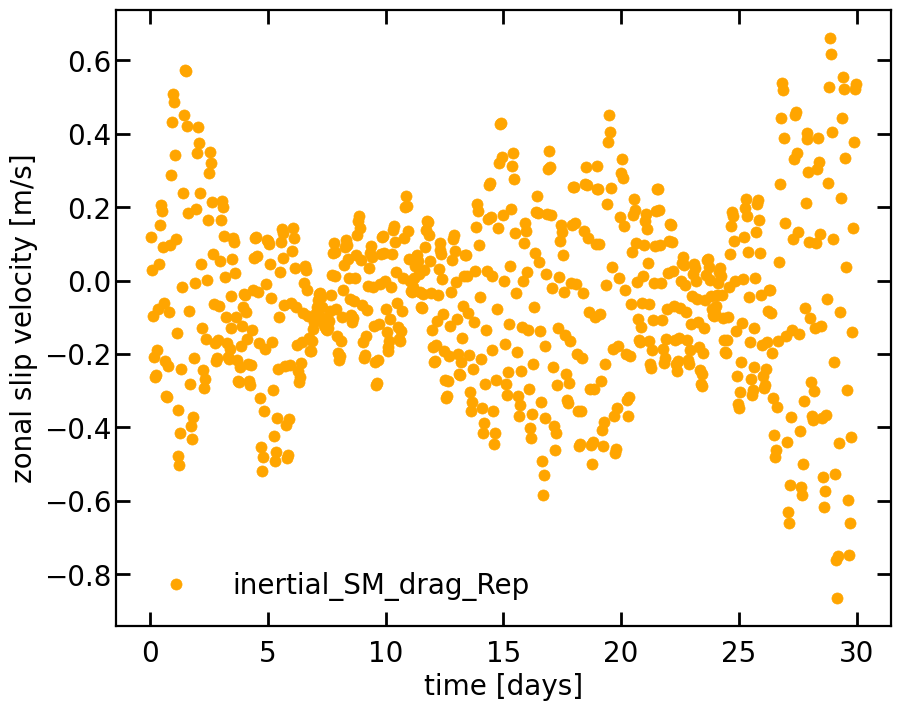

In [35]:
# plot slip velocity
id=54634
fig, ax = plt.subplots()
pt = 'inertial_SM_drag_Rep'
# for pt, color, marker in zip(particle_types,color_array,marker_array):
ax.plot((data_Rep_var_1month[pt].time[id,1:]-data_Rep_var_1month[pt].time[id,0])/sec_in_hours/24,data_Rep_var_1month[pt].uslip[id,1:],marker,color=color)   


ax.legend(particle_types)
ax.set_ylabel('zonal slip velocity [m/s]')
ax.set_xlabel('time [days]')

In [36]:
# make PDF and CDF for reynoldsnumber
mean_Rep_var_month={}
bins_Rep_var_month={}
pdfs_Rep_var_month={}
cdfs_Rep_var_month={}
mean_Rep_var_over_month={}

for pt in particle_types:
    Re_p = Re_particle(data_Rep_var_1month[pt].Uslip,diameter, kinematic_viscosity_water)
    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]
    array=array[array<100000]
    Repmean =Re_p.where(Re_p<100000)
    mean_Rep_var_month[pt]=np.mean(array)
    mean_Rep_var_over_month[pt]=Repmean.mean(dim='trajectory', skipna=True)
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_var_month[pt]=bins
    pdfs_Rep_var_month[pt]=pdf
    cdfs_Rep_var_month[pt]=cdf

Text(0.5, 0, 'Re$_p$')

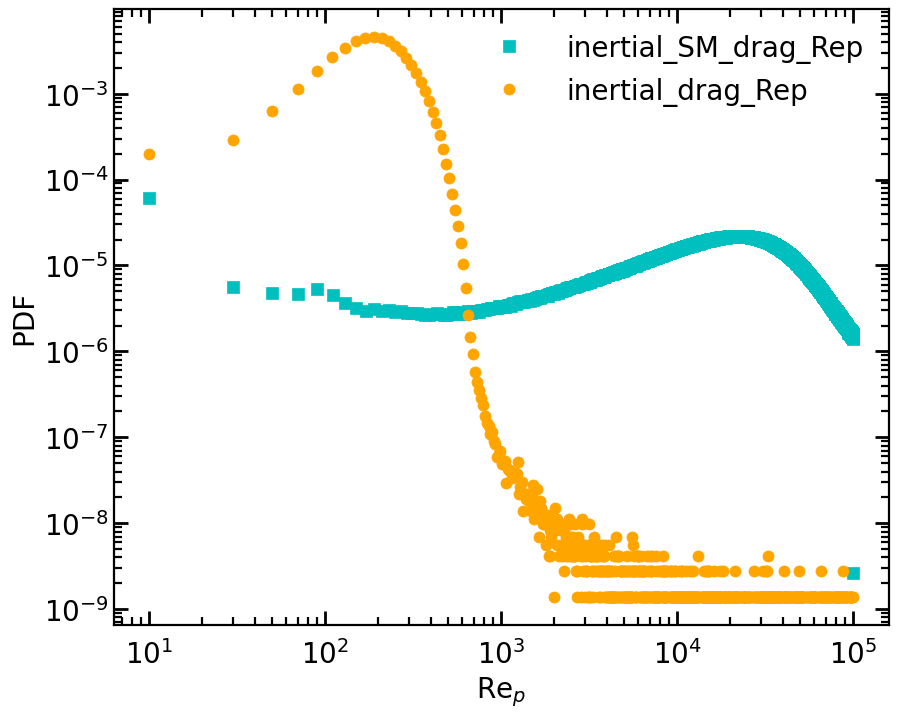

In [37]:
# plot pdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,marker_array,color_array):
   
   ax.plot(bins_Rep_var_month[pt],pdfs_Rep_var_month[pt],marker,color=color)


ax.legend(particle_types)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

Text(0.5, 0, 'Re$_p$')

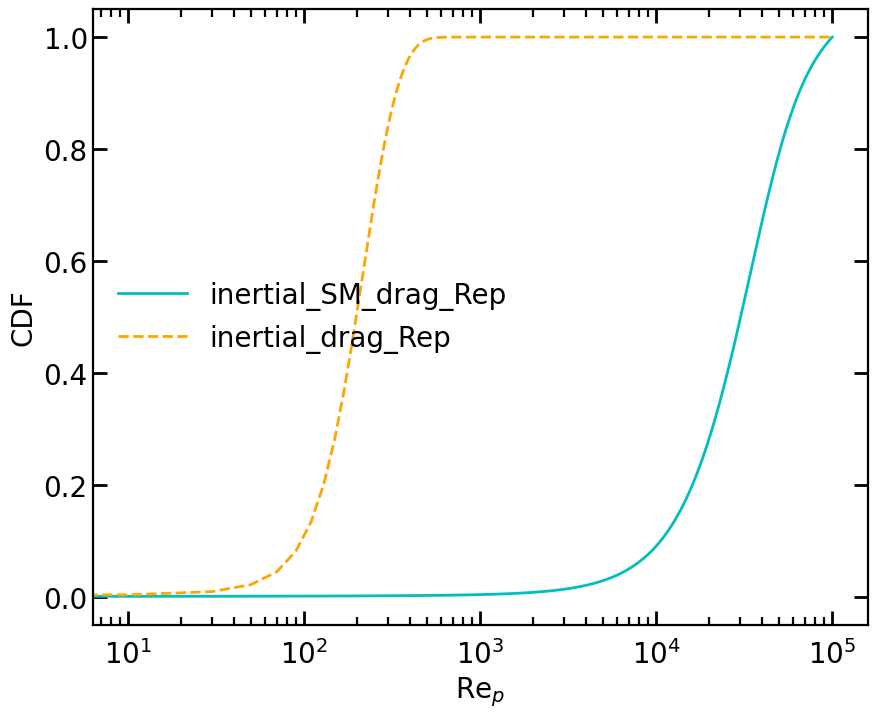

In [38]:
# plot CDF
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(particle_types,line_array,color_array):
   
   ax.plot(bins_Rep_var_month[pt],cdfs_Rep_var_month[pt],marker,color=color)


ax.legend(particle_types)
ax.set_xscale('log')


ax.set_ylabel('CDF')
ax.set_xlabel('Re$_p$')

(46.0, 61.3)

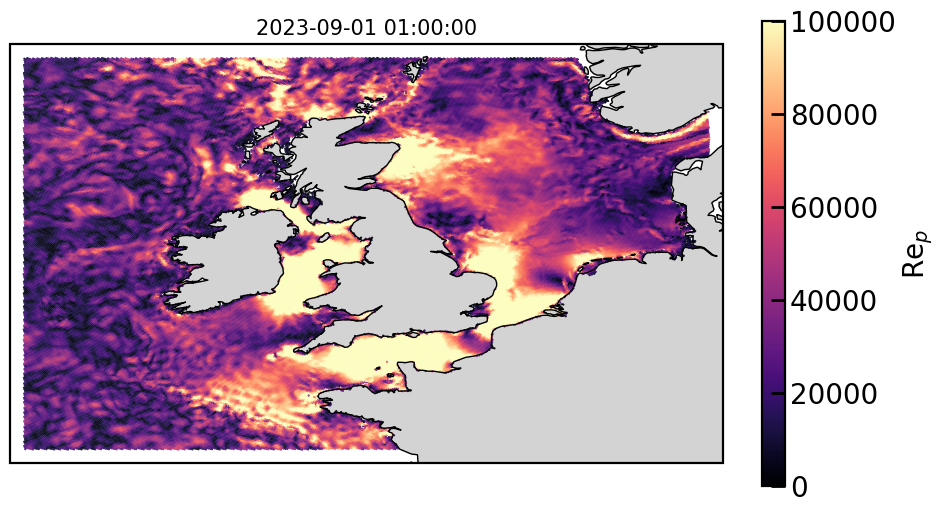

In [45]:
# scatter plot for reynolds number 
pt = 'inertial_SM_drag_Rep'
Re_p = Re_particle(data_Rep_var_1month[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
tid = 1


fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND,color='lightgrey')
sec = float(data_Rep_var_1month[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
ax.set_title(f'{date}', fontsize=15)
scp = ax.scatter(data_Rep_var_1month[pt].lon[::1,tid].T,data_Rep_var_1month[pt].lat[::1,tid].T,c=Re_p[::1,tid].T,s=0.3, vmin=0,vmax=100000,cmap='magma')
# fig.colorbar(scp,label='$\\nu_{\\mathrm{eff}}/\\nu$',fraction=0.03)
fig.colorbar(scp,label='Re$_p$',fraction=0.03)
ax.set_xlim(-16,10)
ax.set_ylim(46,61.3)

In [19]:
# make movies
# make movie out of it
pt = 'inertial_drag_Rep'
Re_p = Re_particle(data_Rep_var_1month[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
for tid in range(1,719,1):

    if(tid % 100 ==0):
        print(tid)

    fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    sec = float(data_Rep_var_1month[pt].time[0,tid].values)
    date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
    ax.set_title(f'{date}', fontsize=15)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,color='lightgrey')
    ax.set_xlim(-16,10)
    ax.set_ylim(46,61.3)
    scp = ax.scatter(data_Rep_var_1month[pt].lon[::1,tid].T,data_Rep_var_1month[pt].lat[::1,tid].T, c=Re_p[::1,tid].T,s=0.3, vmin=0,vmax=1000,cmap='magma')
    fig.colorbar(scp,label='$Re_p$',fraction=0.03)
    fig.tight_layout()
    fig.savefig(f'/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/figures/lagrangian_field/frames/september/Re_particle/1_month_hourly_field/Rep/frames{tid:04d}.png')
    plt.close(fig)

100
200
300
400
500
600
700


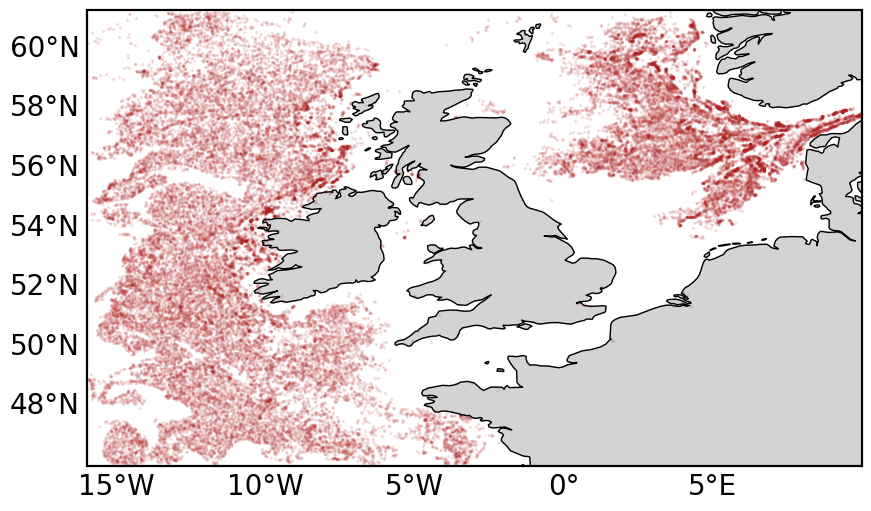

In [47]:
# plot final positon
pt = 'inertial_drag_Rep'
Re_p = Re_particle(data_Rep_var_1month[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
tid = 700


fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND,color='lightgrey')
sec = float(data_Rep_var_1month[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
# ax.set_title(f'{date}', fontsize=15)
scp = ax.scatter(data_Rep_var_1month[pt].lon[::1,tid].T,data_Rep_var_1month[pt].lat[::1,tid].T,marker='o',s=2,alpha=0.1,color='firebrick')
# fig.colorbar(scp,label='$\\nu_{\\mathrm{eff}}/\\nu$',fraction=0.03)
# fig.colorbar(scp,label='Re$_p',fraction=0.03)
ax.set_xlim(-16,10)
ax.set_ylim(46,61.3)
ax.add_feature(cart.feature.LAND,facecolor='lightgrey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

In [ ]:
fig, ax = plt.subplots()
id=1
for pt, marker, color in zip(particle_types,marker_array,color_array):
    ax.plot((data_Rep_var_1month[pt].time[id]-data_Rep_var_1month[pt].time[id,0])/sec_in_hours/24,mean_Rep_var_over_month[pt], marker, color=color )

#need small timestepping (30s) for full MR to agree with SM MR

# Measuring Rep in daily averaged field (24 h)
As Rep will on the magnitude of the velocity values in the velocity field and depend on the velocity and derivatives I also measured the slip velocity (and thus the Rep value) in daily detided field to see if this makes a big difference

In [48]:
file = {}
file['MR'] = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_drag_Rep/NWES_start2023_09_01_tres_daily_end2023_09_02_RK4_B0680_tau2759_anti_beaching_cor_True.zarr'
file['MRSM'] = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM_drag_Rep/NWES_start2023_09_01_tres_daily_end2023_09_02_RK4_B0680_tau2759_anti_beaching_cor_True.zarr'
ptypes = ['MR','MRSM']

In [49]:
chunck_time = 100
nparticles = 88347
ds_daily={}

for pt in ptypes:
    ds = xr.open_dataset(file[pt],
                                        engine='zarr',
                                        chunks={'trajectory':nparticles, 'obs':chunck_time},
                                        drop_variables=['B','tau','z'],
                                        decode_times=False) #,decode_cf=False)

    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    ds_daily[pt]=ds



Text(0.5, 0, 'time [hours]')

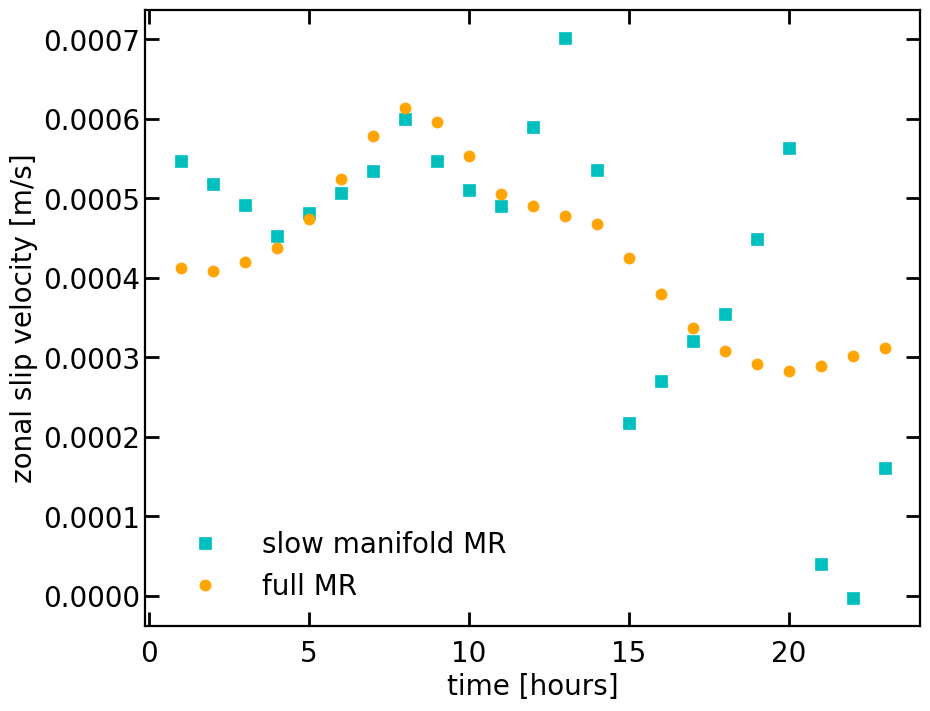

In [50]:
id=54634
fig, ax = plt.subplots()

for pt, color, marker in zip(ptypes, color_array,marker_array):

    ax.plot((ds_daily[pt].time[id,1:]-ds_daily[pt].time[id,0])/sec_in_hours,ds_daily[pt].uf[id,1:],marker,color=color)   


ax.legend(['slow manifold MR','full MR'])
ax.set_ylabel('zonal slip velocity [m/s]')
ax.set_xlabel('time [hours]')

In [ ]:
# make PDF and CDF for reynoldsnumber
mean_Rep_daily_field_24h={}
bins_Rep_daily_field_24h={}
pdfs_Rep_daily_field_24h={}
cdfs_Rep_daily_field_24h={}


for pt in ptypes:
    Re_p = Re_particle(ds_daily[pt].Uslip,diameter, kinematic_viscosity_water)
    array = Re_p.values.flatten()
    array=array[~np.isnan(array)]
    array=array[array<100000]
    Repmean =Re_p.where(Re_p<100000)
    mean_Rep_daily_field_24h[pt]=np.mean(array)
    # mean_Rep_daily_field_24h[pt]=Repmean.mean(dim='trajectory', skipna=True)
    bins,pdf = make_PDF(array,nbins = 5000, norm = True)#,min=0,max=750000)
    dx=bins[1]-bins[0]
    cdf = np.cumsum(pdf*dx)
    bins_Rep_daily_field_24h[pt]=bins
    pdfs_Rep_daily_field_24h[pt]=pdf
    cdfs_Rep_daily_field_24h[pt]=cdf

In [55]:
for pt in ptypes:
    print(mean_Rep_daily_field_24h[pt])
    print(factor_drag_morrison2013(mean_Rep_daily_field_24h[pt]))



129.90585
4.977733640999672
136.1972
5.110440913047098


Text(0.5, 0, 'Re$_p$')

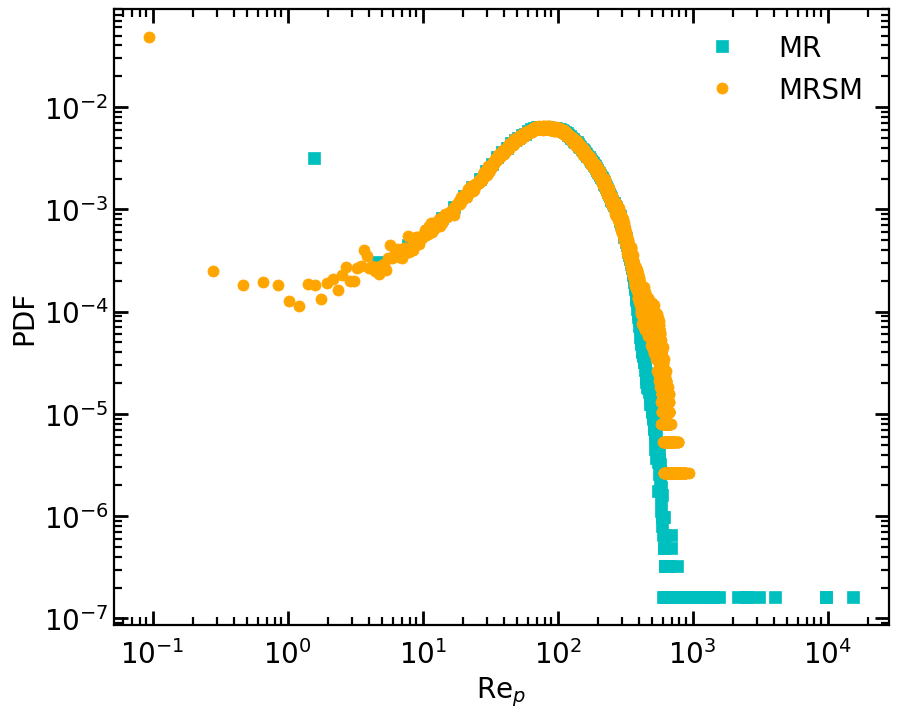

In [52]:
# plot pdfs
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(ptypes,marker_array,color_array):
   
   ax.plot(bins_Rep_daily_field_24h[pt],pdfs_Rep_daily_field_24h[pt],marker,color=color)


ax.legend(ptypes)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('PDF')
ax.set_xlabel('Re$_p$')

Text(0.5, 0, 'Re$_p$')

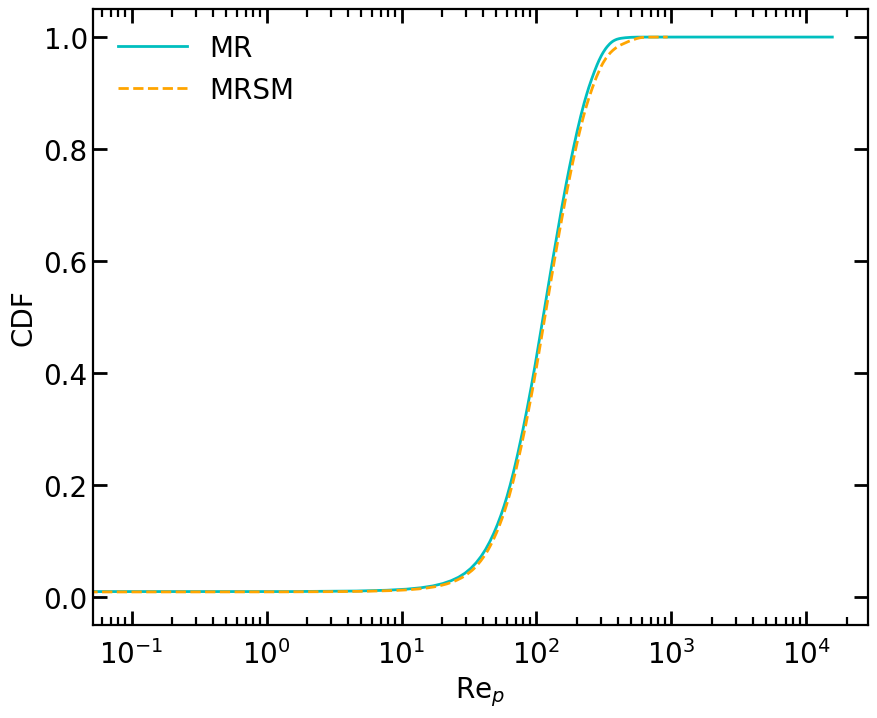

In [53]:
# plot CDF
fig, ax = plt.subplots()
i=0
for pt, marker, color in zip(ptypes,line_array,color_array):
   
   ax.plot(bins_Rep_daily_field_24h[pt],cdfs_Rep_daily_field_24h[pt],marker,color=color)


ax.legend(ptypes)
ax.set_xscale('log')


ax.set_ylabel('CDF')
ax.set_xlabel('Re$_p$')

In [ ]:
for pt in ptypes:
    print(mean_Rep_daily_field_24h[pt])
    print(factor_drag_white1991(mean_Rep_daily_field_24h[pt]))

In [ ]:
# scatter plot for reynolds number 
pt = 'MRSM'
Re_p = Re_particle(ds_daily[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
tid = 3


fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
sec = float(ds_daily[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
ax.set_title(f'{date}', fontsize=15)
scp = ax.scatter(ds_daily[pt].lon[::1,tid].T,ds_daily[pt].lat[::1,tid].T,c=c_rep[::1,tid].T,s=0.3, vmin=0,vmax=20)
fig.colorbar(scp,label='$\\nu_{\\mathrm{eff}}/\\nu$',fraction=0.03)
ax.set_xlim(-16,10)
ax.set_ylim(46,61.3)

## daily fields 1 month simulation varying Reynolds number

In [ ]:
file={}
file['MRSM'] = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM_drag_Rep/NWES_start2023_09_01_tres_daily_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True.zarr'
file['MR'] = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_drag_Rep/NWES_start2023_09_01_tres_daily_end2023_10_01_RK4_B0680_tau2759_anti_beaching_cor_True.zarr'
ptypes = ['MR','MRSM']

In [ ]:
ds_daily_1month={}
for pt in ptypes:
    ds = xr.open_dataset(file[pt],
                                            engine='zarr',
                                            chunks={'trajectory':nparticles, 'obs':chunck_time},
                                            drop_variables=['B','tau','z'],
                                            decode_times=False) #,decode_cf=False)
    if(pt == 'MR'):
        Uslip = np.sqrt(ds.uslip**2 + ds.vslip**2)  
    else:
        Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    ds.Uslip[:,0]=np.nan
    ds_daily_1month[pt]=ds

In [ ]:
pt = 'MR'
Re_p = Re_particle(ds_daily_1month[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
tid = 3


fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND,color='lightgrey')
sec = float(ds_daily_1month[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
ax.set_title(f'{date}', fontsize=15)
scp = ax.scatter(ds_daily_1month[pt].lon[::1,tid].T,ds_daily_1month[pt].lat[::1,tid].T,c=c_rep[::1,tid].T,s=0.3, vmin=0,vmax=30,cmap='magma')
fig.colorbar(scp,label='$\\nu_{\\mathrm{eff}}/\\nu$',fraction=0.03)
ax.set_xlim(-16,10)
ax.set_ylim(46,61.3)

In [ ]:
# make movies
# make movie out of it
pt = 'MRSM'
Re_p = Re_particle(ds_daily_1month[pt].Uslip,diameter, kinematic_viscosity_water)
c_rep = factor_drag_white1991(Re_p)
for tid in range(1,719,1):

    if(tid % 100 ==0):
        print(tid)

    fig, ax= plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    sec = float(ds_daily_1month[pt].time[0,tid].values)
    date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
    ax.set_title(f'{date}', fontsize=15)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,color='lightgrey')
    ax.set_xlim(-16,10)
    ax.set_ylim(46,61.3)
    scp = ax.scatter(ds_daily_1month[pt].lon[::1,tid].T,ds_daily_1month[pt].lat[::1,tid].T,c=c_rep[::1,tid].T,s=0.3, vmin=0,vmax=30,cmap='magma')
    fig.colorbar(scp,label='$Re_p$',fraction=0.03)
    fig.tight_layout()
    fig.savefig(f'/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/figures/lagrangian_field/frames/september/Re_particle/1_month_daily_field/crep/frames{tid:04d}.png')
    plt.close(fig)

In [ ]:
file_in_tracer = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/tracer/NWES_start2023_09_01_tres_daily_end2023_10_01_RK4_anti_beaching_vorticity_False.zarr'


In [ ]:
ds_tracer_daily = ds = xr.open_dataset(file_in_tracer,engine='zarr',
                                            chunks={'trajectory':nparticles, 'obs':chunck_time},
                                            drop_variables=['B','tau','z'],
                                            decode_times=False) #,decode_cf=False)

In [ ]:
tid=719
fig, axs= plt.subplots(1,2,figsize=(25,12),subplot_kw={'projection':ccrs.PlateCarree()})
sec = float(ds_daily_1month[pt].time[0,tid].values)
date =  datetime(2023, 9, 1, 0, 0, 0, 0) + timedelta(seconds =sec)
for ax in axs:
    ax.set_title(f'{date}', fontsize=15)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND,color='lightgrey')
    ax.set_xlim(-16,0)
    ax.set_ylim(46,61.3)
# axs[0].scatter(ds_tracer_daily.lon[::1,tid].T,ds_tracer_daily.lat[::1,tid],color='orange',s=1,alpha=0.2)
axs[0].scatter(ds_daily_1month[pt].lon[::1,tid].T,ds_daily_1month[pt].lat[::1,tid],color='black',s=4,alpha=0.2)



# axs[1].scatter(ds_daily_1month[pt].lon[::1,tid].T,ds_daily_1month[pt].lat[::1,tid],color='orange',s=1,alpha=0.2)
axs[1].scatter(ds_tracer_daily.lon[::1,tid].T,ds_tracer_daily.lat[::1,tid],color='black',s=4,alpha=0.2)